# 连续吸引子神经网络的核心概念

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/routhleck/canns/HEAD?filepath=docs%2Fzh%2Fnotebooks%2F03_core_concepts.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/routhleck/canns/blob/master/docs/zh/notebooks/03_core_concepts.ipynb)

本笔记本全面介绍了连续吸引子神经网络（CANNs）的数学基础和关键概念。理解这些概念对于有效使用 CANNs 库和设计您自己的实验至关重要。

## 目录

1. [数学基础](#数学基础)
2. [网络动态](#网络动态)
3. [连接模式](#连接模式)
4. [吸引子动态](#吸引子动态)
5. [群体编码](#群体编码)
6. [慢特征分析（SFA）](#慢特征分析)
7. [分层网络](#分层网络)
8. [实际应用](#实际应用)

## 数学基础

### 基本网络方程

CANN 的动态由以下微分方程控制：

$$\tau \frac{du_i}{dt} = -u_i + \sum_j W_{ij} r_j + I_i^{ext}$$

其中：
- $u_i$：神经元 $i$ 的膜电位
- $\tau$：时间常数
- $W_{ij}$：从神经元 $j$ 到神经元 $i$ 的连接权重
- $r_j$：神经元 $j$ 的放电率
- $I_i^{ext}$：神经元 $i$ 的外部输入

让我们实现并可视化这个过程。首先配置matplotlib的中文字体：

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import brainstate
from canns.models.basic import CANN1D, CANN2D
from canns.task.tracking import SmoothTracking1D
from canns.analyzer.visualize import energy_landscape_1d_animation

# 设置环境
brainstate.environ.set(dt=0.05)  # 更小的时间步长以获得更好的精度
print("Environment configured")

Environment configured


In [2]:
# 创建一个简单的 CANN 来检查其属性
cann = CANN1D(num=128)
cann.init_state()

print(f"Network properties:")
print(f"- Number of neurons: {cann.shape[0]}")
print(f"- Feature space: [{cann.x.min():.2f}, {cann.x.max():.2f}]")
print(f"- Connection matrix shape: {cann.conn_mat.shape}")
print(f"- Time constant τ: {getattr(cann, 'tau', 'Not directly accessible')}")

Network properties:
- Number of neurons: 128
- Feature space: [-3.14, 3.14]
- Connection matrix shape: (128, 128)
- Time constant τ: 1.0


## 网络动态

### 激活函数

放电率通常通过激活函数与膜电位相关：

$$r_i = f(u_i) = \max(0, u_i)^n$$

其中 $n$ 控制非线性（通常 $n=2$ 表示二次非线性）。

让我们可视化不同的激活函数：

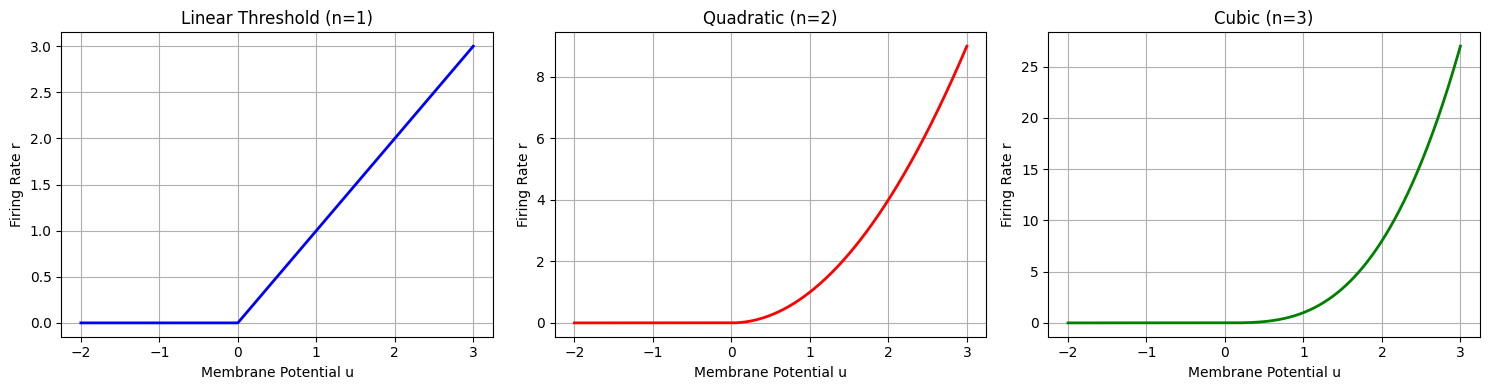

Higher nonlinearity (larger n) leads to sharper, more localized activity patterns.


In [3]:
# 可视化激活函数
u_range = np.linspace(-2, 3, 1000)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 线性阈值（ReLU）
relu = np.maximum(0, u_range)
axes[0].plot(u_range, relu, 'b-', linewidth=2)
axes[0].set_title('Linear Threshold (n=1)')
axes[0].set_xlabel('Membrane Potential u')
axes[0].set_ylabel('Firing Rate r')
axes[0].grid(True)

# 二次
quadratic = np.maximum(0, u_range)**2
axes[1].plot(u_range, quadratic, 'r-', linewidth=2)
axes[1].set_title('Quadratic (n=2)')
axes[1].set_xlabel('Membrane Potential u')
axes[1].set_ylabel('Firing Rate r')
axes[1].grid(True)

# 三次
cubic = np.maximum(0, u_range)**3
axes[2].plot(u_range, cubic, 'g-', linewidth=2)
axes[2].set_title('Cubic (n=3)')
axes[2].set_xlabel('Membrane Potential u')
axes[2].set_ylabel('Firing Rate r')
axes[2].grid(True)

plt.tight_layout()
plt.show()

print("Higher nonlinearity (larger n) leads to sharper, more localized activity patterns.")

## 连接模式

### 墨西哥帽连接

CANNs 通常使用"墨西哥帽"连接模式，具有：
- 短程兴奋
- 长程抑制

位置 $x_i$ 和 $x_j$ 处神经元之间的连接权重为：

$$W(x_i, x_j) = J_{ex} \exp\left(-\frac{|x_i - x_j|^2}{2\sigma_{ex}^2}\right) - J_{in} \exp\left(-\frac{|x_i - x_j|^2}{2\sigma_{in}^2}\right)$$

其中 $J_{ex}, J_{in}$ 分别是兴奋和抑制强度，$\sigma_{ex}, \sigma_{in}$ 是它们各自的范围。

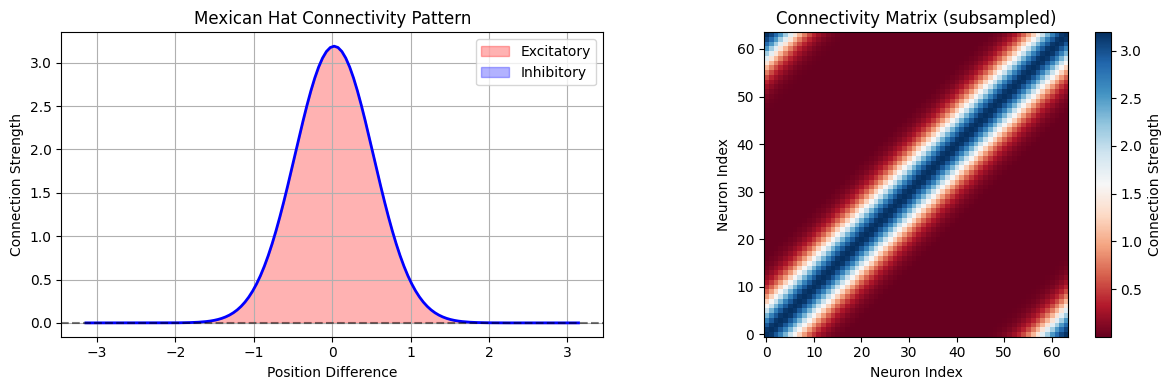

Connectivity statistics:
- Max excitation: 3.1915
- Max inhibition: 0.0000
- Excitatory range: ~61 neurons
- Inhibitory range: ~0 neurons


In [4]:
# Examine the connectivity pattern
center_neuron = cann.shape[0] // 2
connectivity = cann.conn_mat[center_neuron, :]
positions = cann.x

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot connectivity profile
ax1.plot(positions, connectivity, 'b-', linewidth=2)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax1.set_title('Mexican Hat Connectivity Pattern')
ax1.set_xlabel('Position Difference')
ax1.set_ylabel('Connection Strength')
ax1.grid(True)

# Highlight excitatory and inhibitory regions
excitatory_mask = connectivity > 0
inhibitory_mask = connectivity < 0
ax1.fill_between(positions[excitatory_mask], connectivity[excitatory_mask], 
                alpha=0.3, color='red', label='Excitatory')
ax1.fill_between(positions[inhibitory_mask], connectivity[inhibitory_mask], 
                alpha=0.3, color='blue', label='Inhibitory')
ax1.legend()

# Show full connectivity matrix (subsampled for visualization)
step = max(1, cann.shape[0] // 64)  # Subsample for better visualization
conn_subset = cann.conn_mat[::step, ::step]
im = ax2.imshow(conn_subset, cmap='RdBu', origin='lower')
ax2.set_title('Connectivity Matrix (subsampled)')
ax2.set_xlabel('Neuron Index')
ax2.set_ylabel('Neuron Index')
plt.colorbar(im, ax=ax2, label='Connection Strength')

plt.tight_layout()
plt.show()

print(f"Connectivity statistics:")
print(f"- Max excitation: {connectivity.max():.4f}")
print(f"- Max inhibition: {connectivity.min():.4f}")
print(f"- Excitatory range: ~{np.sum(connectivity > 0.01 * connectivity.max())} neurons")
print(f"- Inhibitory range: ~{np.sum(connectivity < 0.01 * connectivity.min())} neurons")

## 吸引子动态

### 连续吸引子

CANNs 的关键特性是连续吸引子的存在——在网络状态空间中形成连续流形的稳定状态。这些吸引子使得：

1. **无离散状态的记忆**：网络可以维持连续吸引子上的任何位置
2. **输入的积分**：在吸引子状态之间平滑移动
3. **鲁棒表示**：小的扰动会被吸引子动态纠正

让我们通过跟踪实验来演示这一点：

In [5]:
# Create a tracking task to demonstrate attractor dynamics
task = SmoothTracking1D(
    cann_instance=cann,
    Iext=(-1.5, 0., 1.5, 0., 0.),  # Move through different positions
    duration=(15., 15., 15., 15.),  # Longer durations to see settling
    time_step=brainstate.environ.get_dt()
)
task.get_data()

print(f"Created tracking task with {len(task.data)} time steps")

<SmoothTracking1D> Generating Task data: 1200it [00:00, 5871.31it/s]

Created tracking task with 1200 time steps


In [7]:
# Run simulation to observe attractor dynamics
def run_step(t, inputs):
    cann(inputs)
    return cann.u.value, cann.inp.value

print("Running attractor dynamics simulation...")
us, inps = brainstate.compile.for_loop(
    run_step,
    task.run_steps,
    task.data,
    pbar=brainstate.compile.ProgressBar(10)
)
print("Simulation complete!")

/Users/sichaohe/Documents/GitHub/canns/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running attractor dynamics simulation...


Running for 1,200 iterations: 100%|██████████| 1200/1200 [00:00<00:00, 347642.27it/s]

Simulation complete!


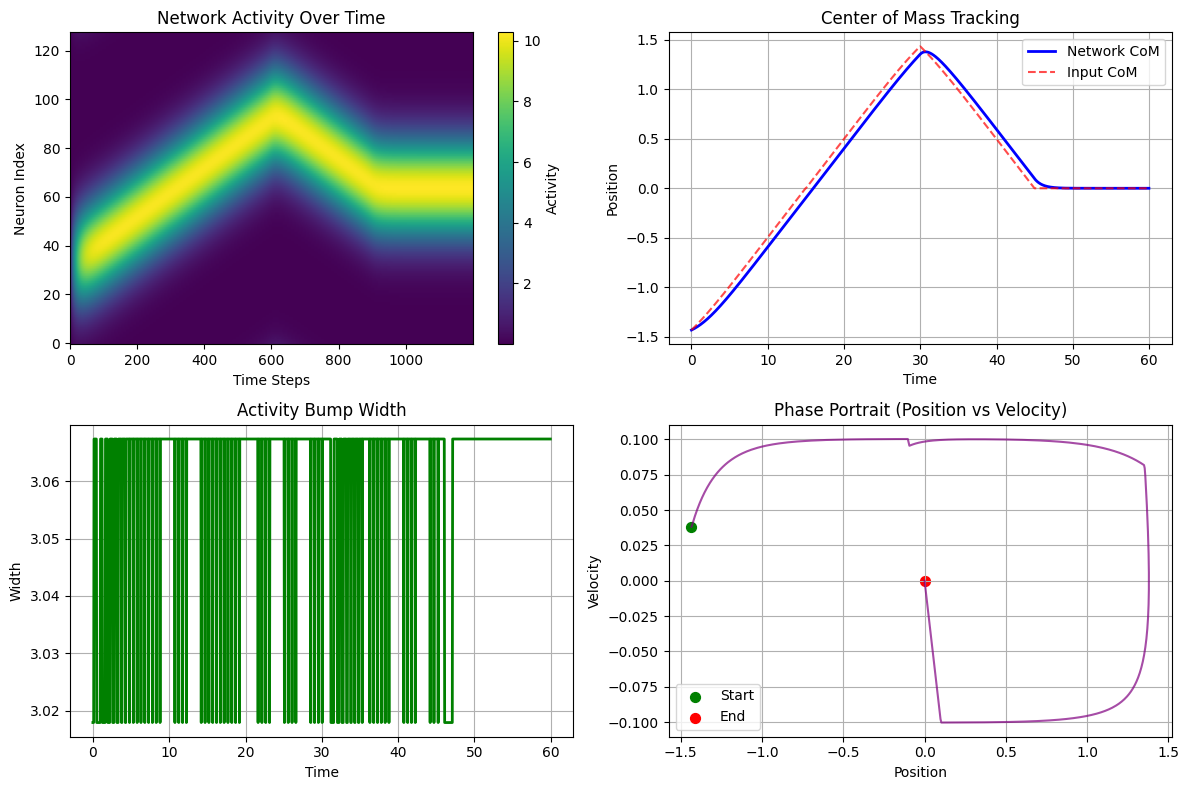

Attractor analysis:
- Final tracking error: 0.0000
- Average bump width: 3.0618 ± 0.0157
- Position range covered: [-1.43, 1.38]


In [8]:
# Analyze attractor properties
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Activity evolution over time
im1 = axes[0,0].imshow(us.T, aspect='auto', origin='lower', cmap='viridis')
axes[0,0].set_title('Network Activity Over Time')
axes[0,0].set_xlabel('Time Steps')
axes[0,0].set_ylabel('Neuron Index')
plt.colorbar(im1, ax=axes[0,0], label='Activity')

# 2. Center of mass tracking
def center_of_mass(activity):
    return np.sum(activity * cann.x) / np.sum(activity)

com_network = np.array([center_of_mass(u) for u in us])
com_input = np.array([center_of_mass(inp) for inp in inps])

time_axis = np.arange(len(us)) * brainstate.environ.get_dt()
axes[0,1].plot(time_axis, com_network, 'b-', linewidth=2, label='Network CoM')
axes[0,1].plot(time_axis, com_input, 'r--', alpha=0.7, label='Input CoM')
axes[0,1].set_title('Center of Mass Tracking')
axes[0,1].set_xlabel('Time')
axes[0,1].set_ylabel('Position')
axes[0,1].legend()
axes[0,1].grid(True)

# 3. Activity width over time (measure of bump sharpness)
def activity_width(activity, threshold=0.1):
    max_act = activity.max()
    if max_act > 0:
        above_threshold = activity > threshold * max_act
        return np.sum(above_threshold) * (cann.x[1] - cann.x[0])
    return 0

widths = np.array([activity_width(u) for u in us])
axes[1,0].plot(time_axis, widths, 'g-', linewidth=2)
axes[1,0].set_title('Activity Bump Width')
axes[1,0].set_xlabel('Time')
axes[1,0].set_ylabel('Width')
axes[1,0].grid(True)

# 4. Phase portrait (simplified - position vs velocity)
com_velocity = np.gradient(com_network) / brainstate.environ.get_dt()
axes[1,1].plot(com_network[:-1], com_velocity[:-1], 'purple', alpha=0.7)
axes[1,1].scatter(com_network[0], com_velocity[0], color='green', s=50, label='Start')
axes[1,1].scatter(com_network[-1], com_velocity[-1], color='red', s=50, label='End')
axes[1,1].set_title('Phase Portrait (Position vs Velocity)')
axes[1,1].set_xlabel('Position')
axes[1,1].set_ylabel('Velocity')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

print(f"Attractor analysis:")
print(f"- Final tracking error: {abs(com_network[-1] - com_input[-1]):.4f}")
print(f"- Average bump width: {widths.mean():.4f} ± {widths.std():.4f}")
print(f"- Position range covered: [{com_network.min():.2f}, {com_network.max():.2f}]")

## 群体编码

### 分布式表示

CANNs 使用群体编码，其中：
- 信息由许多神经元的活动模式编码
- 每个神经元都有一个偏好位置（调谐曲线）
- 群体响应表示当前状态

解码位置可以计算为：
$$\hat{x} = \frac{\sum_i r_i x_i}{\sum_i r_i}$$

这是活动分布的质心。

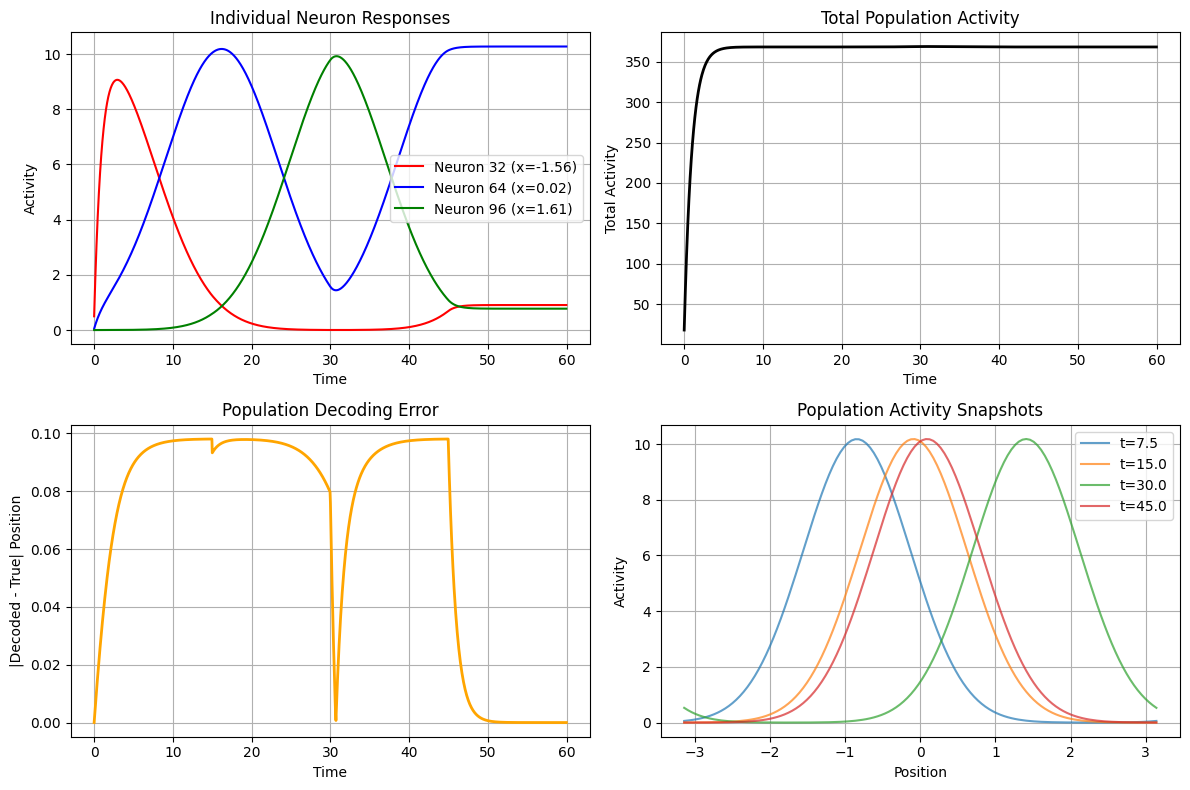

Population coding analysis:
- Mean decoding error: 0.0675
- Max decoding error: 0.0980
- Activity range: [17.95, 368.81]


In [9]:
# Analyze population coding properties
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Individual neuron tuning curves
# Sample a few neurons across the network
sample_neurons = [cann.shape[0]//4, cann.shape[0]//2, 3*cann.shape[0]//4]
colors = ['red', 'blue', 'green']

for i, (neuron_idx, color) in enumerate(zip(sample_neurons, colors)):
    # Get activity of this neuron across all time steps when input was present
    neuron_activity = us[:, neuron_idx]
    axes[0,0].plot(time_axis, neuron_activity, color=color, 
                   label=f'Neuron {neuron_idx} (x={cann.x[neuron_idx]:.2f})')

axes[0,0].set_title('Individual Neuron Responses')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Activity')
axes[0,0].legend()
axes[0,0].grid(True)

# 2. Population vector length (total activity)
total_activity = np.sum(us, axis=1)
axes[0,1].plot(time_axis, total_activity, 'k-', linewidth=2)
axes[0,1].set_title('Total Population Activity')
axes[0,1].set_xlabel('Time')
axes[0,1].set_ylabel('Total Activity')
axes[0,1].grid(True)

# 3. Decoding accuracy over time
decoding_error = np.abs(com_network - com_input)
axes[1,0].plot(time_axis, decoding_error, 'orange', linewidth=2)
axes[1,0].set_title('Population Decoding Error')
axes[1,0].set_xlabel('Time')
axes[1,0].set_ylabel('|Decoded - True| Position')
axes[1,0].grid(True)

# 4. Activity distribution at different time points
time_samples = [len(us)//8, len(us)//4, len(us)//2, 3*len(us)//4]
for i, t_idx in enumerate(time_samples):
    axes[1,1].plot(cann.x, us[t_idx], alpha=0.7, 
                   label=f't={time_axis[t_idx]:.1f}')

axes[1,1].set_title('Population Activity Snapshots')
axes[1,1].set_xlabel('Position')
axes[1,1].set_ylabel('Activity')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

print(f"Population coding analysis:")
print(f"- Mean decoding error: {decoding_error.mean():.4f}")
print(f"- Max decoding error: {decoding_error.max():.4f}")
print(f"- Activity range: [{total_activity.min():.2f}, {total_activity.max():.2f}]")

## 慢特征分析（SFA）

### 时间动态

SFA 模型结合了更慢的动态来处理时间积分：

$$\tau_s \frac{dv_i}{dt} = -v_i + u_i$$

其中 $v_i$ 表示慢变量，$\tau_s >> \tau$ 是慢时间常数。

这创建了一个多时间尺度系统，对路径积分和工作记忆很有用。

In [10]:
# Compare regular CANN with SFA model
from canns.models.basic import CANN1D_SFA

# Create SFA model
cann_sfa = CANN1D_SFA(num=128)
cann_sfa.init_state()

print(f"Created SFA model with {cann_sfa.shape[0]} neurons")
print(f"SFA model has slow dynamics for temporal integration")

Created SFA model with 128 neurons
SFA model has slow dynamics for temporal integration


In [11]:
# Create a task with brief inputs to see memory effects
brief_task = SmoothTracking1D(
    cann_instance=cann_sfa,
    Iext=(1.0, 0.0, 0.0, -1.0, -1.0),  # Brief inputs with gaps
    duration=(3., 10., 10., 3.),  # Short stimulus, long gap
    time_step=brainstate.environ.get_dt()
)
brief_task.get_data()

# Run SFA simulation
def run_sfa_step(t, inputs):
    cann_sfa(inputs)
    return cann_sfa.u.value, cann_sfa.inp.value  # Note: SFA might have different variables

print("Running SFA simulation...")
us_sfa, inps_sfa = brainstate.compile.for_loop(
    run_sfa_step,
    brief_task.run_steps,
    brief_task.data,
    pbar=brainstate.compile.ProgressBar(5)
)
print("SFA simulation complete!")

<SmoothTracking1D> Generating Task data: 520it [00:00, 12759.83it/s]


Running SFA simulation...


Running for 520 iterations: 100%|██████████| 520/520 [00:00<00:00, 185037.59it/s]

SFA simulation complete!


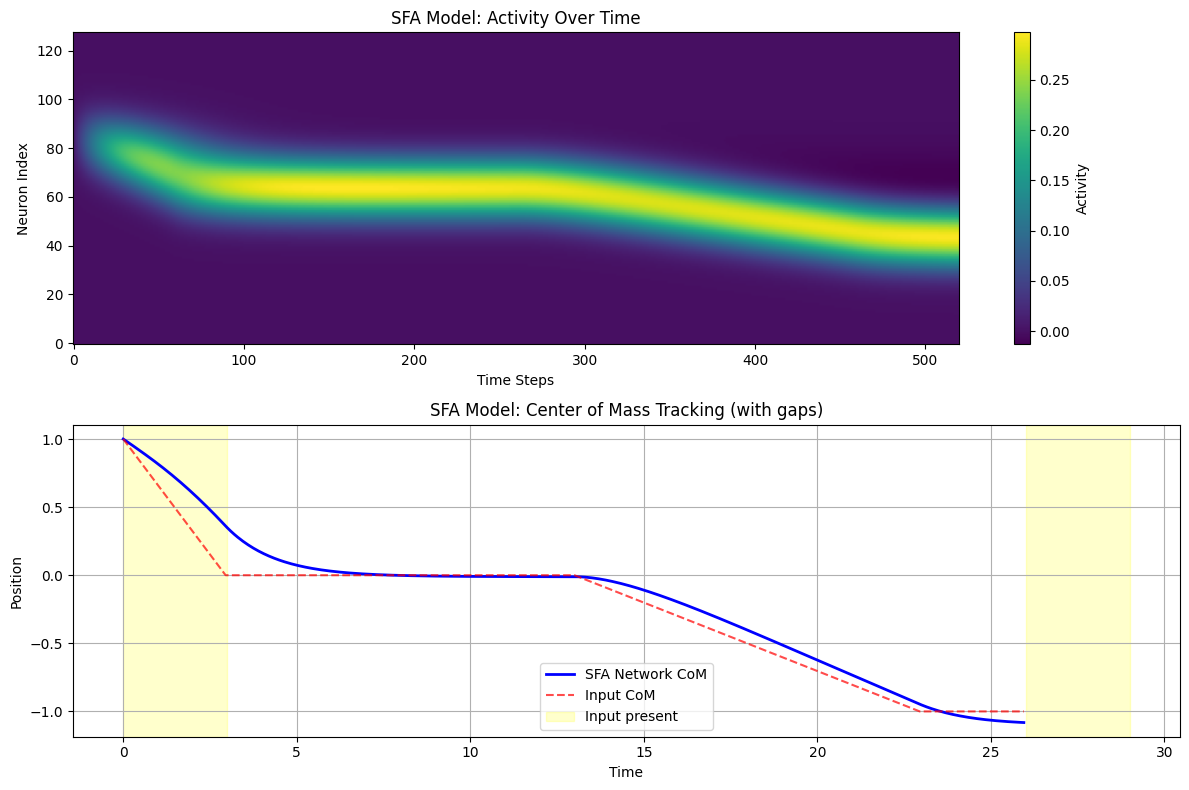

SFA effects:
- Network maintains activity during input gaps
- Slower dynamics provide temporal integration
- Useful for path integration and working memory tasks


In [12]:
# Visualize SFA effects
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

time_axis_sfa = np.arange(len(us_sfa)) * brainstate.environ.get_dt()

# Activity over time
im1 = axes[0].imshow(us_sfa.T, aspect='auto', origin='lower', cmap='viridis')
axes[0].set_title('SFA Model: Activity Over Time')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Neuron Index')
plt.colorbar(im1, ax=axes[0], label='Activity')

# Center of mass comparison
com_sfa = np.array([center_of_mass(u) for u in us_sfa])
com_input_sfa = np.array([center_of_mass(inp) for inp in inps_sfa])

axes[1].plot(time_axis_sfa, com_sfa, 'b-', linewidth=2, label='SFA Network CoM')
axes[1].plot(time_axis_sfa, com_input_sfa, 'r--', alpha=0.7, label='Input CoM')
axes[1].set_title('SFA Model: Center of Mass Tracking (with gaps)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Position')
axes[1].legend()
axes[1].grid(True)

# Highlight input periods
input_periods = [(0, 3), (26, 29)]  # Approximate input periods
for start_t, end_t in input_periods:
    axes[1].axvspan(start_t, end_t, alpha=0.2, color='yellow', label='Input present' if start_t == 0 else '')
if len(input_periods) > 0:
    axes[1].legend()

plt.tight_layout()
plt.show()

print(f"SFA effects:")
print(f"- Network maintains activity during input gaps")
print(f"- Slower dynamics provide temporal integration")
print(f"- Useful for path integration and working memory tasks")

## 分层网络

### 多层处理

分层网络结合多个 CANNs 来创建复杂的处理管道：

- **较低层**：处理详细的局部信息
- **较高层**：在更大尺度上整合信息
- **跨层连接**：实现自上而下和自下而上的处理

这种架构特别适用于：
- 多尺度空间表示
- 分层路径积分
- 复杂决策制定

In [13]:
# Create a simple hierarchical network
from canns.models.basic import HierarchicalNetwork

# Create hierarchical network (if available)
try:
    hierarchical = HierarchicalNetwork(
        layers=[64, 32, 16],  # Three layers with decreasing resolution
        # Add other parameters as needed
    )
    hierarchical.init_state()
    
    print(f"Created hierarchical network with layers: {[64, 32, 16]}")
    print(f"Total parameters: ~{sum([l**2 for l in [64, 32, 16]])} connections")
    
    # Demonstrate multi-scale representation
    # (Implementation would depend on the actual HierarchicalNetwork class)
    
except Exception as e:
    print(f"Hierarchical network demo not available: {e}")
    print("This would demonstrate multi-layer processing and cross-scale interactions")

Hierarchical network demo not available: HierarchicalNetwork.__init__() got an unexpected keyword argument 'layers'
This would demonstrate multi-layer processing and cross-scale interactions


## 实际应用

### 设计考虑

在使用 CANNs 时，请考虑以下关键因素：

1. **网络大小**：
   - 更多神经元 → 更好的分辨率但更高的计算成本
   - 典型范围：1D 为 64-512 神经元，2D 为 32x32 到 64x64

2. **连接参数**：
   - 兴奋/抑制平衡影响稳定性
   - 连接宽度决定空间分辨率

3. **时间常数**：
   - 快动态用于快速跟踪
   - 慢动态用于记忆和积分

4. **输入特性**：
   - 输入强度影响跟踪速度
   - 输入宽度影响最终波包宽度

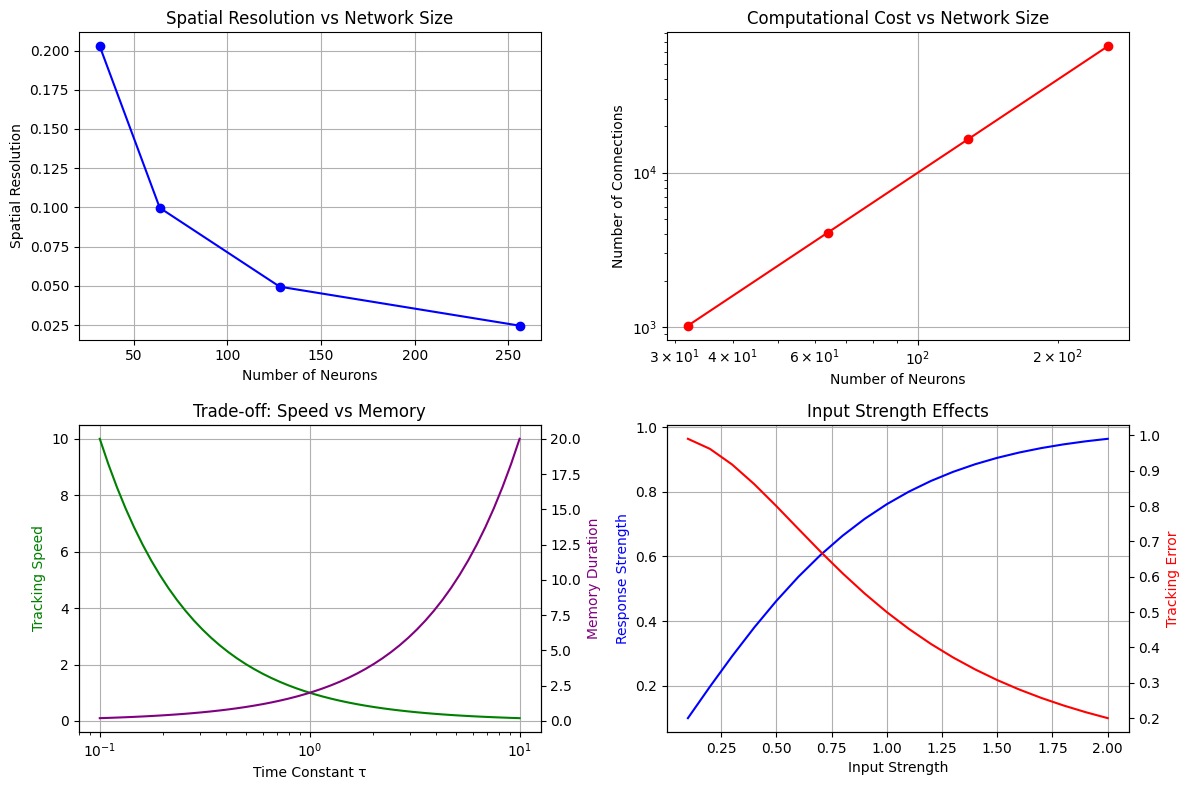


Design Guidelines:
1. Choose network size based on required spatial resolution
2. Balance computational cost with accuracy needs
3. Adjust time constants for speed vs stability trade-off
4. Use appropriate input strengths to avoid saturation


In [14]:
# Demonstrate parameter effects
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Network size effects
sizes = [32, 64, 128, 256]
resolutions = [(cann_x := CANN1D(num=size).x)[1] - cann_x[0] for size in sizes]
axes[0,0].plot(sizes, resolutions, 'bo-')
axes[0,0].set_title('Spatial Resolution vs Network Size')
axes[0,0].set_xlabel('Number of Neurons')
axes[0,0].set_ylabel('Spatial Resolution')
axes[0,0].grid(True)

# 2. Computational cost
connections = [size**2 for size in sizes]  # Approximate
axes[0,1].loglog(sizes, connections, 'ro-')
axes[0,1].set_title('Computational Cost vs Network Size')
axes[0,1].set_xlabel('Number of Neurons')
axes[0,1].set_ylabel('Number of Connections')
axes[0,1].grid(True)

# 3. Time constant effects (conceptual)
time_constants = np.logspace(-1, 1, 50)
tracking_speed = 1.0 / time_constants  # Inverse relationship
memory_duration = time_constants * 2  # Proportional relationship

axes[1,0].semilogx(time_constants, tracking_speed, 'g-', label='Tracking Speed')
ax_twin = axes[1,0].twinx()
ax_twin.semilogx(time_constants, memory_duration, 'purple', label='Memory Duration')
axes[1,0].set_xlabel('Time Constant τ')
axes[1,0].set_ylabel('Tracking Speed', color='g')
ax_twin.set_ylabel('Memory Duration', color='purple')
axes[1,0].set_title('Trade-off: Speed vs Memory')
axes[1,0].grid(True)

# 4. Input strength effects
input_strengths = np.linspace(0.1, 2.0, 20)
response_strengths = np.tanh(input_strengths)  # Saturating response
tracking_errors = 1.0 / (1 + input_strengths**2)  # Decreasing error

axes[1,1].plot(input_strengths, response_strengths, 'b-', label='Response Strength')
ax_twin2 = axes[1,1].twinx()
ax_twin2.plot(input_strengths, tracking_errors, 'r-', label='Tracking Error')
axes[1,1].set_xlabel('Input Strength')
axes[1,1].set_ylabel('Response Strength', color='b')
ax_twin2.set_ylabel('Tracking Error', color='r')
axes[1,1].set_title('Input Strength Effects')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

print("\nDesign Guidelines:")
print("1. Choose network size based on required spatial resolution")
print("2. Balance computational cost with accuracy needs")
print("3. Adjust time constants for speed vs stability trade-off")
print("4. Use appropriate input strengths to avoid saturation")

## 总结

本笔记本涵盖了 CANNs 的核心数学和概念基础：

### 涵盖的关键概念：

1. **数学基础**：控制网络动态的微分方程
2. **网络动态**：激活函数和时间演化
3. **连接模式**：墨西哥帽连接实现吸引子形成
4. **吸引子动态**：稳定状态的连续流形
5. **群体编码**：分布式表示和解码
6. **慢特征分析**：用于积分的多时间尺度动态
7. **分层网络**：多层处理架构
8. **实际应用**：设计考虑和权衡

### 下一步：

现在您了解了核心概念，您可以：

- 在下一个笔记本中探索详细的 **1D CANN 实现**
- 了解复杂环境中的 **2D 空间表示**
- 实现针对您研究需求的 **自定义任务**
- 应用 **高级可视化技术** 进行分析
- 为大规模仿真优化 **性能**

### 进一步学习的资源：

- **数学细节**：查看原始的 CANN 论文和综述
- **实现示例**：查看 `examples/` 目录
- **API 文档**：所有类和函数的完整参考
- **社区支持**：参与讨论并从其他用户获得帮助

您在这里构建的坚实基础将在您深入特定应用和高级技术时为您提供良好的服务！🧠🔬